# Implementation Convolutional Bayesian Denoising Autoencoder Alzheimer MRI Scan Dataset


## Data loading and processing

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
!pip install -q tensorflow
%load_ext tensorboard

from skimage.metrics import structural_similarity as ssim

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

random_seed = 42
# Set random seed
torch.manual_seed(random_seed)
np.random.seed(random_seed)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [27]:
import os
import glob
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

image_size = 128

class MRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith('.jpeg') or fname.endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')
        image.draft('L', (image_size, image_size))

        if self.transform:
            image = self.transform(image)

        # If you have labels, modify this part to return the corresponding label as well.
        return (image, 0)

# Define the path to your dataset
dataset_path = '/content/drive/MyDrive/mri_dataset'

# Define any transformations (e.g., normalization, resizing)
transform = transforms.Compose([
    # transforms.Resize((image_size, image_size)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Create an instance of the dataset
xray_dataset = MRIDataset(root_dir=dataset_path, transform=transform)

print(len(xray_dataset))

# Split dataset into train/validation/test sets
train_indices, temp_indices = train_test_split(np.arange(len(xray_dataset)), test_size=0.3, random_state=random_seed)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=random_seed)

# Create data loaders
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

train_loader = DataLoader(xray_dataset, batch_size=64, sampler=train_sampler)
val_loader = DataLoader(xray_dataset, batch_size=64, sampler=val_sampler)
test_loader = DataLoader(xray_dataset, batch_size=64, sampler=test_sampler)

# Checking dataset sizes
print(f'Training dataset size: {len(train_sampler)}')
print(f'Validation dataset size: {len(val_sampler)}')
print(f'Test dataset size: {len(test_sampler)}')

print(len(train_loader))


6400
Training dataset size: 4480
Validation dataset size: 960
Test dataset size: 960
70


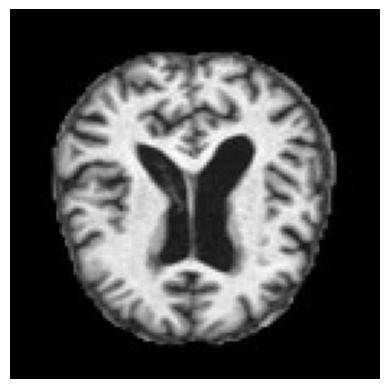

In [5]:
# Get the first batch of data
data_iter = iter(train_loader)
images, _ = next(data_iter)

# Extract the first image from the batch
first_image = images[0]

# Convert tensor to image
first_image = first_image.squeeze().numpy()  # Squeeze removes the single channel dimension
first_image = first_image * 255  # Undo normalization

# Plot the image
plt.imshow(first_image, cmap='gray')
plt.axis('off')
plt.show()

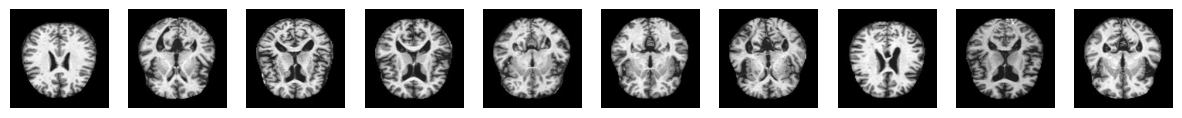

In [6]:
# Get a batch of training data
data_iter = iter(train_loader)
images, _ = next(data_iter)

# Plot the first 10 images
fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
for i in range(10):
    ax = axes[i]
    ax.imshow(images[i].numpy().squeeze(), cmap='gray')
    ax.axis('off')
    # ax.set_title('Label: {}'.format(labels[i].item()))

plt.show()

## Autoencoder Architectures

In [7]:
dropout_rate = 0.1

def MC_dropout(act_vec, p=0.5, mask=True):
  return F.dropout(act_vec, p=p, training=mask, inplace=False)

Linear models

In [8]:
class LinearBDAE(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder layers
        self.enc_fc1 = nn.Linear(image_size*image_size, 1024)
        self.enc_fc2 = nn.Linear(1024, 512)
        self.enc_fc3 = nn.Linear(512, 256)

        # Decoder layers
        self.dec_fc1 = nn.Linear(256, 512)
        self.dec_fc2 = nn.Linear(512, 1024)
        self.dec_fc3 = nn.Linear(1024, image_size*image_size)

    def forward(self, x, dropout_p=dropout_rate, apply_dropout=True):
        # Encoder forward pass
        x = F.relu(self.enc_fc1(x))
        x = F.relu(self.enc_fc2(x))
        x = F.relu(self.enc_fc3(x))

        # Decoder forward pass with MC Dropout
        x = F.relu(self.dec_fc1(x))
        x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = F.relu(self.dec_fc2(x))
        x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = torch.sigmoid(self.dec_fc3(x))
        return x

    def sample_predict(self, x, Nsamples):
      predictions = x.data.new(Nsamples, x.shape[0], image_size*image_size)
      for i in range(Nsamples):
        y = self.forward(x)
        predictions[i] = y

      predictions_mean = torch.mean(predictions, dim=0)
      predictions_var = torch.var(predictions, dim=0)

      return predictions, predictions_mean, predictions_var


class LinearDAE(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder layers
        self.enc_fc1 = nn.Linear(image_size*image_size, 1024)
        self.enc_fc2 = nn.Linear(1024, 512)
        self.enc_fc3 = nn.Linear(512, 256)

        # Decoder layers
        self.dec_fc1 = nn.Linear(256, 512)
        self.dec_fc2 = nn.Linear(512, 1024)
        self.dec_fc3 = nn.Linear(1024, image_size*image_size)

    def forward(self, x, dropout_p=dropout_rate, apply_dropout=True):
        # Encoder forward pass
        x = F.relu(self.enc_fc1(x))
        x = F.relu(self.enc_fc2(x))
        x = F.relu(self.enc_fc3(x))

        # Decoder forward pass with MC Dropout
        x = F.relu(self.dec_fc1(x))
        # x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = F.relu(self.dec_fc2(x))
        # x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = torch.sigmoid(self.dec_fc3(x))
        return x

    def sample_predict(self, x, Nsamples):
      predictions = x.data.new(Nsamples, x.shape[0], image_size*image_size)
      for i in range(Nsamples):
        y = self.forward(x)
        predictions[i] = y

      predictions_mean = torch.mean(predictions, dim=0)
      predictions_var = torch.var(predictions, dim=0)

      return predictions, predictions_mean, predictions_var

In [9]:
class ConvolutionalBDAE(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder layers
        self.conv1 = nn.Conv2d(1, 64, 3, stride=2, padding=1)  # Increased number of output channels
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)  # Increased number of output channels
        self.conv3 = nn.Conv2d(128, 256, 7)  # Increased number of output channels

        # Decoder layers
        self.deconv1 = nn.ConvTranspose2d(256, 128, 7)  # Increased number of input channels
        self.deconv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)  # Increased number of input channels
        self.deconv3 = nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1)  # Increased number of input channels
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, dropout_p=dropout_rate, apply_dropout=True):
        # Encoder
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Decoder
        x = F.relu(self.deconv1(x))
        x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = F.relu(self.deconv2(x))
        x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = self.sigmoid(self.deconv3(x))

        return x

    def sample_predict(self, x, Nsamples):
      predictions = x.data.new(Nsamples, x.shape[0], image_size*image_size)
      for i in range(Nsamples):
        y = self.forward(x)
        predictions[i] = y.view(-1, image_size*image_size)

      predictions_mean = torch.mean(predictions, dim=0)
      predictions_var = torch.var(predictions, dim=0)

      predictions_mean = predictions_mean.view(-1, 1, image_size, image_size)
      predictions_var = predictions_var.view(-1, 1, image_size, image_size)

      return predictions, predictions_mean, predictions_var


class ConvolutionalDAE(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder layers
        self.conv1 = nn.Conv2d(1, 64, 3, stride=2, padding=1)  # Increased number of output channels
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)  # Increased number of output channels
        self.conv3 = nn.Conv2d(128, 256, 7)  # Increased number of output channels

        # Decoder layers
        self.deconv1 = nn.ConvTranspose2d(256, 128, 7)  # Increased number of input channels
        self.deconv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)  # Increased number of input channels
        self.deconv3 = nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1)  # Increased number of input channels
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, dropout_p=0.1, apply_dropout=True):
        # Encoder
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Decoder
        x = F.relu(self.deconv1(x))
        # x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = F.relu(self.deconv2(x))
        # x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = self.sigmoid(self.deconv3(x))

        return x

    def sample_predict(self, x, Nsamples):
      predictions = x.data.new(Nsamples, x.shape[0], image_size*image_size)
      for i in range(Nsamples):
        y = self.forward(x)
        predictions[i] = y.view(-1, image_size*image_size)

      predictions_mean = torch.mean(predictions, dim=0)
      predictions_var = torch.var(predictions, dim=0)

      predictions_mean = predictions_mean.view(-1, 1, image_size, image_size)
      predictions_var = predictions_var.view(-1, 1, image_size, image_size)

      return predictions, predictions_mean, predictions_var

## Noise schemes

In [10]:
def add_gaussian_noise(images, noise_factor=0.5):
  corrupted_images = images + noise_factor * torch.randn(*images.shape)
  corrupted_images = np.clip(corrupted_images, 0., 1.)
  return corrupted_images

## Training Process

## Evaluation

### Load models

In [11]:
from skimage.metrics import structural_similarity as ssim

def load_model(model_class, model_path, device='cpu'):
    model = model_class()
    checkpoint = torch.load(model_path, map_location=torch.device(device))

    # Check if the checkpoint contains 'model_state_dict'
    if 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint

    model.load_state_dict(state_dict)
    model.eval()  # Set to evaluation mode
    return model

In [12]:
# Paths to the saved models
model_paths_mri = {
    'linear_bdae_mri': '/content/drive/MyDrive/ES_linear_mri/mri_ES_linear_bdae_lr=0.001_seed=42.pth',
    'linear_dae_mri': '/content/drive/MyDrive/ES_linear_mri/mri_ES_linear_dae_lr=0.001_seed=43.pth',
    'convolutional_bdae_mri': '/content/mri_ES_convolutional_bdae_lr=0.001_seed=42.pth',
    'convolutional_dae_mri': '/content/mri_ES_convolutional_dae_lr=0.001_seed=43.pth'
}

# Dictionary to hold the loaded models
loaded_models_mri = {}

# Load each model
loaded_models_mri['linear_bdae_mri'] = load_model(LinearBDAE, model_paths_mri['linear_bdae_mri'], device)
loaded_models_mri['linear_dae_mri'] = load_model(LinearDAE, model_paths_mri['linear_bdae_mri'], device)
loaded_models_mri['convolutional_bdae_mri'] = load_model(ConvolutionalBDAE, model_paths_mri['convolutional_bdae_mri'], device)
loaded_models_mri['convolutional_dae_mri'] = load_model(ConvolutionalDAE, model_paths_mri['convolutional_dae_mri'], device)

### MSE and SSIM

In [13]:
def linear_test(val_loader, net, criterion, Nsamples, noise_factor):
    total_loss = 0
    total_ssim = 0
    mse_values = []
    predictions_var_values = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Ensure device is set

    net.to(device)  # Move model to the appropriate device

    # Use torch.no_grad to skip gradient calculation, not needed for evaluation
    with torch.no_grad():
        # iterate through batches
        for data in tqdm(val_loader):
            # get the inputs; data is a list of [inputs, labels]
            images, _ = data
            images = images.view(images.size(0), -1)

            corrupted_images = add_gaussian_noise(images, noise_factor=noise_factor)

            images = images.to(device)
            corrupted_images = corrupted_images.to(device)

            # forward pass
            predictions, predictions_mean, predictions_var = net.sample_predict(corrupted_images, Nsamples)
            loss = criterion(predictions_mean, images)

            # Calculate SSIM
            ssim_score = ssim(predictions_mean.cpu().numpy(), images.cpu().numpy(), multichannel=True)
            total_ssim += np.mean(ssim_score)

            # Calculate MSE and variance
            # mse = torch.mean((predictions_mean - images)**2).item()
            # predictions_var_value = torch.mean(predictions_var).item()

            mse = (predictions_mean - images)**2
            # Flatten MSE tensor to a numpy array
            mse_flat = mse.view(-1).cpu().numpy()
            var_flat = predictions_var.view(-1).cpu().numpy()

            # Update lists for correlation calculation
            mse_values.append(mse_flat)
            predictions_var_values.append(var_flat)

            # keep track of loss
            total_loss += loss.item() * images.size(0)

    avg_loss = total_loss / len(val_loader.dataset)  # Compute average loss
    avg_ssim = total_ssim / len(val_loader)  # Compute average SSIM

    # Compute correlation between MSE and predictions_var
    mse_values = np.concatenate(mse_values)  # flatten list of arrays into a single array
    predictions_var_values = np.concatenate(predictions_var_values)
    correlation = np.corrcoef(mse_values, predictions_var_values)[0, 1]

    return avg_loss, avg_ssim, correlation, mse_values

In [14]:
def convolutional_test(val_loader, net, criterion, Nsamples, noise_factor):
    total_loss = 0
    total_ssim = 0
    mse_values = []
    predictions_var_values = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Ensure device is set

    net.to(device)  # Move model to the appropriate device

    # Use torch.no_grad to skip gradient calculation, not needed for evaluation
    with torch.no_grad():
        # iterate through batches
        for data in tqdm(val_loader):
            # get the inputs; data is a list of [inputs, labels]
            images, _ = data

            corrupted_images = add_gaussian_noise(images, noise_factor=noise_factor)

            images = images.to(device)
            corrupted_images = corrupted_images.to(device)

            # forward pass
            predictions, predictions_mean, predictions_var = net.sample_predict(corrupted_images, Nsamples)
            loss = criterion(predictions_mean, images)

            # Calculate SSIM
            ssim_score = 0
            for img, output in zip(images, predictions_mean):
                img_np = img.cpu().detach().numpy().transpose(1, 2, 0)  # Assuming images are (batch_size, channels, height, width)
                output_np = output.cpu().detach().numpy().transpose(1, 2, 0)
                ssim_score += ssim(img_np, output_np, multichannel=True)

            ssim_score /= images.size(0)  # Average SSIM for the batch
            total_ssim += ssim_score

            # Calculate MSE and variance
            # mse = torch.mean((predictions_mean - images)**2).item()
            # predictions_var_value = torch.mean(predictions_var).item()

            mse = (predictions_mean - images)**2
            # Flatten MSE tensor to a numpy array
            mse_flat = mse.view(-1).cpu().numpy()
            var_flat = predictions_var.view(-1).cpu().numpy()

            # Update lists for correlation calculation
            mse_values.append(mse_flat)
            predictions_var_values.append(var_flat)

            # keep track of loss
            total_loss += loss.item() * images.size(0)

    avg_loss = total_loss / len(val_loader.dataset)  # Compute average loss
    avg_ssim = total_ssim / len(val_loader)  # Compute average SSIM

    # Compute correlation between MSE and predictions_var
    mse_values = np.concatenate(mse_values)  # flatten list of arrays into a single array
    predictions_var_values = np.concatenate(predictions_var_values)
    correlation = np.corrcoef(mse_values, predictions_var_values)[0, 1]

    return avg_loss, avg_ssim, correlation, mse_values

In [15]:
criterion = nn.MSELoss()

mse_linear_bdae_mri, ssim_linear_bdae_mri, corr_linear_bdae_mri, mse_values = linear_test(test_loader, loaded_models_mri['linear_bdae_mri'], criterion, 50, 0.3)
print(f'MSE of linear_bdae_mri on MRI test set: {mse_linear_bdae_mri}')
print(f'SSIM of linear_bdae_mri on MRI test set: {ssim_linear_bdae_mri}')
print(f'Correlation of linear_bdae_mri on MRI test set: {corr_linear_bdae_mri}')

mse_linear_dae_mri, ssim_linear_dae_mri, corr_linear_dae_mri, _ = linear_test(test_loader, loaded_models_mri['linear_dae_mri'], criterion, 50, 0.3)
print(f'MSE of linear_dae_mri on MRI test set: {mse_linear_dae_mri}')
print(f'SSIM of linear_dae_mri on MRI test set: {ssim_linear_dae_mri}')
print(f'Correlation of linear_dae_mri on MRI test set: {corr_linear_dae_mri}')

mse_convolutional_bdae_mri, ssim_convolutional_bdae_mri, corr_convolutional_bdae_mri, _ = convolutional_test(test_loader, loaded_models_mri['convolutional_bdae_mri'], criterion, 50, 0.3)
print(f'MSE of convolutional_bdae_mri on MRI test set: {mse_convolutional_bdae_mri}')
print(f'SSIM of convolutional_bdae_mri on MRI test set: {ssim_convolutional_bdae_mri}')
print(f'Correlation of convolutional_bdae_mri on MRI test set: {corr_convolutional_bdae_mri}')

mse_convolutional_dae_mri, ssim_convolutional_dae_mri, corr_convolutional_dae_mri, _ = convolutional_test(test_loader, loaded_models_mri['convolutional_dae_mri'], criterion, 50, 0.3)
print(f'MSE of convolutional_dae_mri on MRI test set: {mse_convolutional_dae_mri}')
print(f'SSIM of convolutional_dae_mri on MRI test set: {ssim_convolutional_dae_mri}')
print(f'Correlation of convolutional_dae_mri on MRI test set: {corr_convolutional_dae_mri}')

  0%|          | 0/15 [00:00<?, ?it/s]<ipython-input-13-6999fa8be1cc>:28: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(predictions_mean.cpu().numpy(), images.cpu().numpy(), multichannel=True)
100%|██████████| 15/15 [00:59<00:00,  3.98s/it]


MSE of linear_bdae_mri on MRI test set: 0.0009016938367858529
SSIM of linear_bdae_mri on MRI test set: 0.8748595237731933
Correlation of linear_bdae_mri on MRI test set: 0.2947346840437823


100%|██████████| 15/15 [00:55<00:00,  3.72s/it]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


MSE of linear_dae_mri on MRI test set: 0.0008989554038271308
SSIM of linear_dae_mri on MRI test set: 0.8765084028244019
Correlation of linear_dae_mri on MRI test set: nan


  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
<ipython-input-14-7ac0ae92e1f2>:31: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score += ssim(img_np, output_np, multichannel=True)
100%|██████████| 15/15 [00:26<00:00,  1.79s/it]


MSE of convolutional_bdae_mri on MRI test set: 0.0005328287393786013
SSIM of convolutional_bdae_mri on MRI test set: 0.9017433770000934
Correlation of convolutional_bdae_mri on MRI test set: 0.3176457714918287


100%|██████████| 15/15 [00:26<00:00,  1.79s/it]


MSE of convolutional_dae_mri on MRI test set: 0.0005227730423212052
SSIM of convolutional_dae_mri on MRI test set: 0.9045969690506657
Correlation of convolutional_dae_mri on MRI test set: 0.04589637659392942


### Plots

#### Clean images

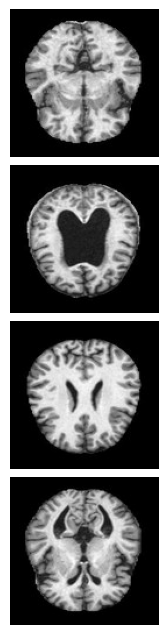

In [28]:
def plot_images(images, num_images=4, space=0.05, cmap='gray', vmax=None):
    plt.figure(figsize=(2, 8))
    for i in range(num_images):
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap=cmap, vmax=vmax)
        plt.axis('off')
    plt.subplots_adjust(wspace=space, hspace=space)
    plt.show()

# Fixing the random seed for DataLoader
torch.manual_seed(42)
np.random.seed(42)

# Get a batch of images from the test set
test_iter = iter(test_loader)
images_batch, labels_batch = next(test_iter)

# Select the first 4 images to display
start_index = 20
images = images_batch[start_index:start_index+4]

plot_images(images, space=0.05, vmax=1)

# print(len(train_loader))

#### Noisy images

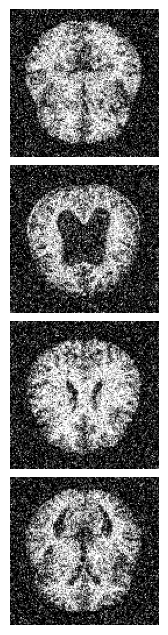

In [35]:
# torch_images = torch.stack(images)

noisy_images = add_gaussian_noise(images, noise_factor=0.3)
plot_images(noisy_images, space=0.05)

#### Linear DAE

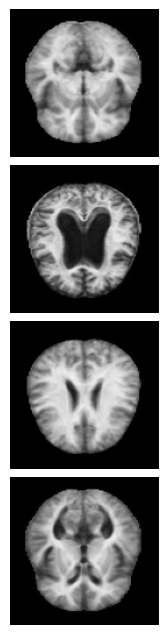

In [36]:
noisy_images_flattened = noisy_images.view(noisy_images.size(0), -1).to(device)
loaded_models_mri['linear_dae_mri'].to(device).eval()
with torch.no_grad():
    _, predictions_mean, predictions_var = loaded_models_mri['linear_dae_mri'].sample_predict(noisy_images_flattened, 50)

plot_images(predictions_mean.view(-1,image_size,image_size).cpu(), space=0.05, vmax=1)

#### Linear BDAE

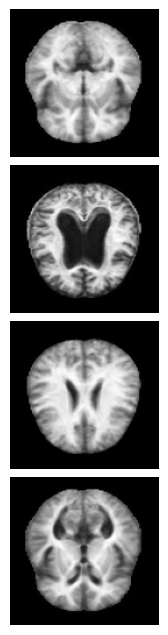

In [37]:
noisy_images_flattened = noisy_images.view(noisy_images.size(0), -1).to(device)
loaded_models_mri['linear_bdae_mri'].eval()
with torch.no_grad():
    _, predictions_mean_linear, predictions_var_linear = loaded_models_mri['linear_bdae_mri'].to(device).sample_predict(noisy_images_flattened, 10)

plot_images(predictions_mean.view(-1,image_size,image_size).cpu(), space=0.05)

#### Model uncertainty Linear BDAE

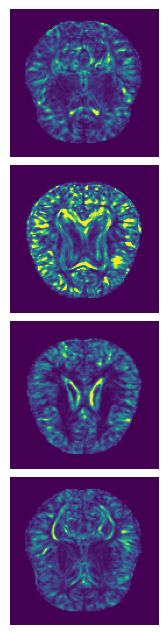

In [38]:
max_pixel = np.max(predictions_var.cpu().numpy()[:4])
# print(max_pixel)

plot_images(predictions_var_linear.view(-1,image_size,image_size).cpu(), space=0.05, cmap='viridis', vmax=0.004)

#### Convolutional DAE

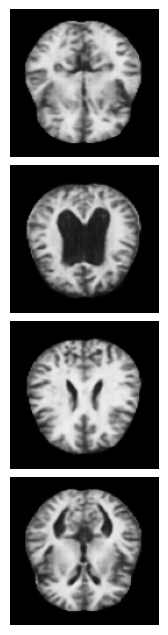

In [39]:
# noisy_images_flattened = noisy_images.view(noisy_images.size(0), -1).to(device)
loaded_models_mri['convolutional_dae_mri'].to(device).eval()
with torch.no_grad():
    _, predictions_mean, predictions_var = loaded_models_mri['convolutional_dae_mri'].sample_predict(noisy_images.to(device), 50)

plot_images(predictions_mean.view(-1,image_size,image_size).cpu(), space=0.05, vmax=1)

#### Convolutional BDAE

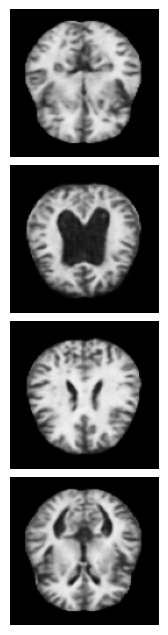

In [40]:
# noisy_images_flattened = noisy_images.view(noisy_images.size(0), -1).to(device)
loaded_models_mri['convolutional_bdae_mri'].to(device).eval()
with torch.no_grad():
    _, predictions_mean, predictions_var = loaded_models_mri['convolutional_bdae_mri'].sample_predict(noisy_images.to(device), 50)

plot_images(predictions_mean.view(-1,image_size,image_size).cpu(), space=0.05, vmax=1)

#### Model uncertainty Convolutional BDAA

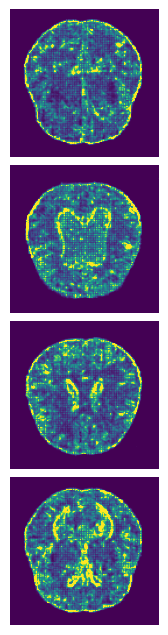

In [41]:
max_pixel = np.max(predictions_var.cpu().numpy()[:4])
# print(max_pixel)

plot_images(predictions_var.view(-1,image_size,image_size).cpu(), space=0.05, cmap='viridis', vmax=0.001)